In [1]:
# Importing necessary libraries
import numpy as np

import time 
from IPython.display import Video
from tqdm.notebook import tqdm

import joblib

# Importing custom modules
from engine_DP import CoinGame
from agents import (
    ManhattanAgent, ManhattanAgent_Passive, ManhattanAgent_Aggressive, ManhattanAgent_Ultra_Aggressive,
    IndQLearningAgent, IndQLearningAgentSoftmax, LevelKQAgent, LevelKQAgentSoftmax,
    LevelKDPAgent_Stationary, LevelKDPAgent_NonStationary, LevelKDPAgent_Dynamic, DPAgent_PerfectModel)

from utils.exploration_schedule_utils import linear_epsilon_decay
from utils.plot_utils import plot, animate_trajectory_from_log

Agents package successfully initialized.


## Experiment setup

In [3]:
## Setup experiment 1

# Number of experiments
N_EXP = 3

# Size of single dimension of the square grid
grid_size = 5

# Initialize environment 
env = CoinGame(max_steps=20000, grid_size=grid_size, push_distance=2)

# Number of states 
n_states = env.n_states

# Number of episodes 
n_iter = 1000

# Constant gamma 
gamma = 0.95

# Learning rate
learning_rate = 0.5

# Moving average window size for plotting 
moving_average_window_size = 100

r0ss = []
r1ss = []

# Setup parameters for linear decay of exploration parameter
epsilon_begin = 1
epsilon_end = 0.1


# Pre-calculate array of linearly decaying exploration parameter for both agents

linear_epsilon_decay_arr = linear_epsilon_decay(epsilon_begin=epsilon_begin, epsilon_end=epsilon_end,n_iter=n_iter)



In [3]:
# Run the experiments
for n in range(N_EXP):
    
    ## Initialize agents
    #* Note: The agent's here are reinitialized, instead reset can be done by reseting the Q matrix inside the agent.
    
    P1 = IndQLearningAgentSoftmax(np.array(range(8)), n_states, learning_rate=learning_rate,
                           epsilon=epsilon_begin, gamma=gamma, beta = 1, player_id=0)
    
    P2 = IndQLearningAgentSoftmax(np.array(range(8)), n_states, learning_rate=learning_rate,
                           epsilon=epsilon_begin, gamma=gamma, beta = 1, player_id=1)


    # P2 = ExpSmoother(env.available_actions_Adv, env.available_actions_Adv, learning_rate=0.7)
    # P2 = RandomAgent( env.available_actions, p=0.5)

    
    # Reset the reward vectors for the experiment
    r0s = []
    r1s = []
    
    # Run through episodes
    for i in range(n_iter):

        # Initialize the end of episode flag
        done = False
        # Reset the environment after each episode
        env.reset()
        # Get the initial state
        s = env.get_state()
        
        # Initialize cummulative observed rewards for this episode
        episode_rewards_DM = 0
        episode_rewards_Adv = 0
        
        # While the agents have not reached the terminal state
        while not done:
            # Agents choose actions 
            # * Note: They choose the actions simultaneously
            a1 = P1.act(obs=s)
            a2 = P2.act(obs=s)

            # Transition to next time step
            s_new, rewards, done =  env.step((a1,a2))

            # Agents update their Q/Value functions
            # * Note: They update their Q/Value functions simultaneously
            P1.update(s, (a1, a2), s_new, (rewards[0], rewards[1]))
            P2.update(s, (a2, a1), s_new, (rewards[1], rewards[0]))
            
            # Set the current state to the new state
            s = s_new  
            
            # Add the observed reward to the episode reward of both agents 
            # * Note: The rewards are observed simultaneously
            episode_rewards_DM += rewards[0]
            episode_rewards_Adv += rewards[1]
            
        # After an epoch apply decay to exploration parameter
        P1.epsilon = linear_epsilon_decay_arr[i]
        # P1.enemy.epsilon = linear_epsilon_decay_arr[i]
        # P1.enemy.enemy.epsilon = linear_epsilon_decay_arr[i]
        P2.epsilon = linear_epsilon_decay_arr[i]
            
        # Append the episode rewards to the list of rewards for this experiment
        r0s.append(episode_rewards_DM)
        # Append the episode rewards to the list of rewards for this experiment
        r1s.append(episode_rewards_Adv)
        
        env.reset()
    
          

    print(n)
    r0ss.append(r0s)
    r1ss.append(r1s)
    
plot(r0ss, r1ss, moving_average_window_size=moving_average_window_size, dir=None)

TypeError: IndQLearningAgentSoftmax.__init__() missing 1 required positional argument: 'grid_size'

Experiments:   0%|          | 0/3 [00:00<?, ?it/s]

Initializing value function.:   0%|          | 0/10000 [00:00<?, ?it/s]

Initializing value function.:   0%|          | 0/10000 [00:00<?, ?it/s]

Epochs (Exp 1):   0%|          | 0/1000 [00:00<?, ?it/s]

Initializing value function.:   0%|          | 0/10000 [00:00<?, ?it/s]

Initializing value function.:   0%|          | 0/10000 [00:00<?, ?it/s]

Epochs (Exp 2):   0%|          | 0/1000 [00:00<?, ?it/s]

Initializing value function.:   0%|          | 0/10000 [00:00<?, ?it/s]

Initializing value function.:   0%|          | 0/10000 [00:00<?, ?it/s]

Epochs (Exp 3):   0%|          | 0/1000 [00:00<?, ?it/s]

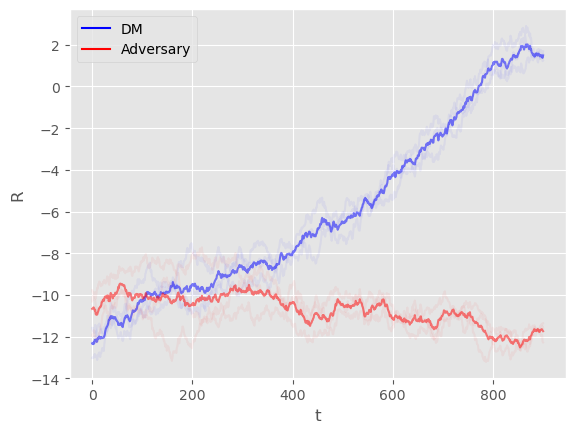

In [3]:
r0ss = []
r1ss = []

# Total trajectory logs for all experiments
trajectory_logs_all_experiments = []

# Run the experiments
for n in tqdm(range(N_EXP), desc="Experiments"):
    
    np.random.seed(n)
    
    ## Initialize agents
    # TODO: Add reset method to individual agents and move them to initialization
    #* Note: The agent's here are reinitialized, instead reset can be done by reseting the Q matrix inside the agent.
    
    P1 = LevelKQAgent(k=1, action_space=np.array(range(8)), opponent_action_space=np.array(range(8)), lower_level_k_epsilon = 1,
                      n_states=n_states, grid_size=grid_size, learning_rate=learning_rate, epsilon=epsilon_begin, gamma=gamma, initial_Q_value = 0, player_id=0)
    
    # P1 = IndQLearningAgentSoftmax(np.array(range(8)), n_states, learning_rate=learning_rate,
    #                        epsilon=linear_epsilon_decay_arr[0], gamma=gamma, opponent_action_space=None, beta = 1)

    
    P2 = IndQLearningAgentSoftmax(np.array(range(8)), n_states, grid_size=grid_size, learning_rate=learning_rate,
                           epsilon=epsilon_begin, gamma=gamma, initial_Q_value = 0, beta = 1, player_id=1)
    
    # P2 = ManhattanAgent(action_space=np.array(range(8)), coin_location = np.array([env.coin_0_pos, env.player_1_pos]), grid_size = grid_size, player_id = 1)

    # P2 = LevelKQAgent(k=1, action_space=np.array(range(8)), opponent_action_space=np.array(range(8)),
    #                   n_states=n_states, grid_size=grid_size, learning_rate=learning_rate, epsilon=epsilon_begin, gamma=gamma, player_id=1)
    
    # Reset the reward vectors for the experiment
    r0s = []
    r1s = []
    
    # Trajectory logs for visualization
    trajectory_logs_single_experiment = []
    
    # Run through episodes
    for i in tqdm(range(n_iter), desc=f"Epochs (Exp {n+1})"):

        # Initialize the end of episode flag
        done = False
        # Reset the environment after each episode
        env.reset()
        # Get the initial state
        s = env.get_state()
        # Trajectory log for this episode
        trajectory_log_single_epoch = []
        
        # Log the initial state immediately after env.reset()
        trajectory_log_single_epoch.append({
            'DM_location_old': ["None", "None"],
            'Adv_location_old': ["None", "None"],
            'DM_location_new': env.player_0_pos.copy(),
            'Adv_location_new': env.player_1_pos.copy(),
            'coin1': env.coin_0_pos.copy() if env.coin0_available else None,
            'coin2': env.coin_1_pos.copy() if env.coin1_available else None, 
            'action_DM': ["None", "None"],
            'action_Adv': ["None", "None"],
            'reward_DM': None,
            'reward_Adv': None,
            'state': s, 
            'experiment': n,
            'epoch': i
        })

        # Initialize cummulative observed rewards for this episode
        episode_rewards_DM = 0
        episode_rewards_Adv = 0
        
        # While the agents have not reached the terminal state
        while not done:
            # Agents choose actions 
            # * Note: They choose the actions simultaneously
            a1 = P1.act(obs=s, env=None)
            a2 = P2.act(obs=s, env=None)
            
            # Save locations for logging before a step is made
            DM_location_old = env.player_0_pos.copy()
            Adv_location_old = env.player_1_pos.copy()
            
            # Transition to next time step
            s_new, rewards, done =  env.step((a1,a2))

            # Agents update their Q/Value functions
            # * Note: They update their Q/Value functions simultaneously
            P1.update(s, (a1, a2), s_new, (rewards[0], rewards[1]))
            P2.update(s, (a1, a2), s_new, (rewards[0], rewards[1]))
            
            # Set the current state to the new state
            s = s_new  
            
            # Add the observed reward to the episode reward of both agents 
            # * Note: The rewards are observed simultaneously
            episode_rewards_DM += rewards[0]
            episode_rewards_Adv += rewards[1]
        
            # Log state in single episode
            trajectory_log_single_epoch.append({
                'DM_location_old': DM_location_old,
                'Adv_location_old': Adv_location_old,
                'DM_location_new': env.player_0_pos.copy(),
                'Adv_location_new': env.player_1_pos.copy(),
                'coin1': env.coin_0_pos.copy() if env.coin0_available else None,
                'coin2': env.coin_1_pos.copy() if env.coin1_available else None, 
                'action_DM': env.combined_actions[a1],
                'action_Adv': env.combined_actions[a2],
                'reward_DM': rewards[0],
                'reward_Adv': rewards[1],
                'experiment': n,
                'epoch': i
            })
            
        # Append the episode rewards to the list of rewards for this experiment
        r0s.append(episode_rewards_DM)
        # Append the episode rewards to the list of rewards for this experiment
        r1s.append(episode_rewards_Adv)
        
        # Append the trajectory log for this epoch to experiment log 
        trajectory_logs_single_experiment.append(trajectory_log_single_epoch)
        
        # After an epoch apply decay to exploration parameter

        P1.update_epsilon(linear_epsilon_decay_arr[i], linear_epsilon_decay_arr[i])
        P2.update_epsilon(linear_epsilon_decay_arr[i], linear_epsilon_decay_arr[i])
        
            
    # Append the trajectory logs of this experiment to the total logs
    trajectory_logs_all_experiments.append(trajectory_logs_single_experiment)
    
    env.reset() # Reset the environment at the very end
    
    r0ss.append(r0s)
    r1ss.append(r1s)


plot(r0ss, r1ss, moving_average_window_size=moving_average_window_size)

In [6]:
r0ss = []
r1ss = []

# Total trajectory logs for all experiments
trajectory_logs_all_experiments = []

# Run the experiments
for n in tqdm(range(N_EXP), desc="Experiments"):
    
    np.random.seed(n)
    
    ## Initialize agents
    # P2 = IndQLearningAgentSoftmax(np.array(range(8)), n_states, learning_rate=learning_rate,
    #                        epsilon=linear_epsilon_decay_arr[0], gamma=gamma, beta = 1)

    P2 = LevelKDPAgent_Stationary(
        k=1, 
        action_space=np.array(range(len(env.combined_actions))),
        opponent_action_space=np.array(range(len(env.combined_actions))),
        lower_level_k_epsilon=linear_epsilon_decay_arr[0],
        n_states=n_states,
        epsilon=linear_epsilon_decay_arr[0],
        gamma=gamma,
        initial_V_value=0,
        player_id=1,
        env=env
    ) 

    # P2 = ExpSmoother(env.available_actions_Adv, env.available_actions_Adv, learning_rate=0.7)
    # P2 = RandomAgent( env.available_actions, p=0.5)
    
    
    # P2 = LevelKDPAgent_Stationary(
    #     k=2, 
    #     action_space=np.array(range(len(env.combined_actions))),
    #     opponent_action_space=np.array(range(len(env.combined_actions))),
    #     n_states=n_states,
    #     epsilon=linear_epsilon_decay_arr[0],
    #     gamma=gamma,
    #     player_id=1,
    #     env=env
    # ) 
    
    # P2 = ManhattanAgent(action_space=np.array(range(8)), coin_location = np.array([env.coin_0_pos, env.player_1_pos]), grid_size = grid_size, player_id = 1)

    # P2 = LevelKDPAgent_Dynamic(
    #     k=1, 
    #     action_space=np.array(range(len(env.combined_actions))),
    #     opponent_action_space=np.array(range(len(env.combined_actions))),
    #     n_states=n_states,
    #     epsilon=linear_epsilon_decay_arr[0],
    #     gamma=gamma,
    #     player_id=1,
    #     env=env
    # ) 

    
    # P1 = IndQLearningAgentSoftmax(np.array(range(8)), n_states, learning_rate=learning_rate,
    #                        epsilon=linear_epsilon_decay_arr[0], gamma=gamma, opponent_action_space=None, beta = 1)

    
    P1 = LevelKDPAgent_Stationary(
        k=1, 
        action_space=np.array(range(len(env.combined_actions))),
        opponent_action_space=np.array(range(len(env.combined_actions))),
        lower_level_k_epsilon=linear_epsilon_decay_arr[0],
        n_states=n_states,
        epsilon=linear_epsilon_decay_arr[0],
        gamma=gamma,
        initial_V_value=0,
        player_id=0,
        env=env
    ) 
    
    # P1 = LevelKDPAgent_NonStationary(
    #     k=2,
    #     action_space=np.array(range(len(env.combined_actions))),
    #     opponent_action_space=np.array(range(len(env.combined_actions))),
    #     n_states=n_states,
    #     epsilon=linear_epsilon_decay_arr[0],
    #     gamma=gamma,
    #     player_id=0,
    #     env=env
    # ) 
    
    # P1 = LevelKDPAgent_Dynamic(
    #     k=2, 
    #     action_space=np.array(range(len(env.combined_actions))),
    #     opponent_action_space=np.array(range(len(env.combined_actions))),
    #     n_states=n_states,
    #     epsilon=linear_epsilon_decay_arr[0],
    #     gamma=gamma,
    #     player_id=0,
    #     env=env
    # ) 
    
    # P1 = DPAgent_PerfectModel(
    #      action_space = np.array(range(len(env.combined_actions))),
    #      opponent_action_space = np.array(range(len(env.combined_actions))),
    #      n_states=n_states,
    #      gamma=gamma,
    #      player_id=0,
    #      env=env,
    #      enemy=P2
    # ) 
    
    # P1 = ManhattanAgent(action_space=np.array(range(8)), coin_location = np.array([env.coin_0_pos, env.player_1_pos]), grid_size = grid_size, player_id = 0)


    
    # Reset the reward vectors for the experiment
    r0s = []
    r1s = []
    
    # Trajectory logs for visualization
    trajectory_logs_single_experiment = []
    
    # Run through episodes
    for i in tqdm(range(n_iter), desc=f"Epochs (Exp {n+1})"):

        # Initialize the end of episode flag
        done = False
        # Reset the environment after each episode
        env.reset()
        # Get the initial state
        s = env.get_state()
        # Trajectory log for this episode
        trajectory_log_single_epoch = []
        
        # Log the initial state immediately after env.reset()
        trajectory_log_single_epoch.append({
            'DM_location_old': ["None", "None"],
            'Adv_location_old': ["None", "None"],
            'DM_location_new': env.player_0_pos.copy(),
            'Adv_location_new': env.player_1_pos.copy(),
            'coin1': env.coin_0_pos.copy() if env.coin0_available else None,
            'coin2': env.coin_1_pos.copy() if env.coin1_available else None, 
            'action_DM': ["None", "None"],
            'action_Adv': ["None", "None"],
            'reward_DM': None,
            'reward_Adv': None,
            'state': s, 
            'experiment': n,
            'epoch': i
        })

        # Initialize cummulative observed rewards for this episode
        episode_rewards_DM = 0
        episode_rewards_Adv = 0
        s_new = env.get_state()
        # While the agents have not reached the terminal state
        while not done:
            # Agents choose actions 
            # * Note: They choose the actions simultaneously
            a1 = P1.act(obs=s, env=None)
            a2 = P2.act(obs=s, env=None)
            
            # Save locations for logging before a step is made
            DM_location_old = env.player_0_pos.copy()
            Adv_location_old = env.player_1_pos.copy()
            
            # DP agent performs update before next state is evaluated

        
            # Transition to next time step
            s_new, rewards, done =  env.step((a1,a2))


            # Update the Q matrix of adversary
            #P1.update(s, (a1, a2), rewards=(rewards[0], rewards[1]), new_obs=s_new)
            P1.update(s, (a1, a2), new_obs=s_new, rewards = None)
            P2.update(s, (a1, a2), new_obs=s_new, rewards = None)
            #P2.update(s, (a1, a2), rewards=[rewards[0],rewards[1]], new_obs=s_new)
            
            # P2.update(s, (a2, a1), s_new, (rewards[1], rewards[0]))
            # P2.update(s, (a1, a2))

            
            # Set the current state to the new state
            s = s_new  
            
            # Add the observed reward to the episode reward of both agents 
            # * Note: The rewards are observed simultaneously
            episode_rewards_DM += rewards[0]
            episode_rewards_Adv += rewards[1]
        
            # Log state in single episode
            trajectory_log_single_epoch.append({
                'DM_location_old': DM_location_old,
                'Adv_location_old': Adv_location_old,
                'DM_location_new': env.player_0_pos.copy(),
                'Adv_location_new': env.player_1_pos.copy(),
                'coin1': env.coin_0_pos.copy() if env.coin0_available else None,
                'coin2': env.coin_1_pos.copy() if env.coin1_available else None, 
                'action_DM': env.combined_actions[a1],
                'action_Adv': env.combined_actions[a2],
                'reward_DM': rewards[0],
                'reward_Adv': rewards[1],
                'experiment': n,
                'epoch': i
            })
            
        # Append the episode rewards to the list of rewards for this experiment
        r0s.append(episode_rewards_DM)
        # Append the episode rewards to the list of rewards for this experiment
        r1s.append(episode_rewards_Adv)
        
        # Append the trajectory log for this epoch to experiment log 
        trajectory_logs_single_experiment.append(trajectory_log_single_epoch)
        
        # After an epoch apply decay to exploration parameter
        P1.update_epsilon(linear_epsilon_decay_arr[i], linear_epsilon_decay_arr[i])
        P2.update_epsilon(linear_epsilon_decay_arr[i], linear_epsilon_decay_arr[i])
        
    # Append the trajectory logs of this experiment to the total logs
    trajectory_logs_all_experiments.append(trajectory_logs_single_experiment)
    
    env.reset() # Reset the environment at the very end

    r0ss.append(r0s)
    r1ss.append(r1s)

Experiments:   0%|          | 0/3 [00:00<?, ?it/s]

Initializing value function.:   0%|          | 0/10000 [00:00<?, ?it/s]

Pre-computing lookups for Level-1 DP Agent (Player Adv):   0%|          | 0/10000 [00:00<?, ?it/s]

Initializing value function.:   0%|          | 0/10000 [00:00<?, ?it/s]

Pre-computing lookups for Level-1 DP Agent (Player DM):   0%|          | 0/10000 [00:00<?, ?it/s]

Epochs (Exp 1):   0%|          | 0/1000 [00:00<?, ?it/s]

Initializing value function.:   0%|          | 0/10000 [00:00<?, ?it/s]

Pre-computing lookups for Level-1 DP Agent (Player Adv):   0%|          | 0/10000 [00:00<?, ?it/s]

Initializing value function.:   0%|          | 0/10000 [00:00<?, ?it/s]

Pre-computing lookups for Level-1 DP Agent (Player DM):   0%|          | 0/10000 [00:00<?, ?it/s]

Epochs (Exp 2):   0%|          | 0/1000 [00:00<?, ?it/s]

Initializing value function.:   0%|          | 0/10000 [00:00<?, ?it/s]

Pre-computing lookups for Level-1 DP Agent (Player Adv):   0%|          | 0/10000 [00:00<?, ?it/s]

Initializing value function.:   0%|          | 0/10000 [00:00<?, ?it/s]

Pre-computing lookups for Level-1 DP Agent (Player DM):   0%|          | 0/10000 [00:00<?, ?it/s]

Epochs (Exp 3):   0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
# # This is the filename we'll save the agent to
# filename = 'p1_agent.joblib'

# # joblib.dump saves the object to the file
# joblib.dump(P1, filename)

# print(f"Agent P1 successfully saved to {filename}")



# filename = 'p1_agent.joblib'

# # joblib.load reads the object from the file
# P1 = joblib.load(filename)

# print(f"Agent P1 successfully loaded from {filename}")
# print(f"Loaded agent is of type: {type(P1)}")
# print(f"Loaded agent's level k: {P1.k}")


Agent P1 successfully loaded from p1_agent.joblib
Loaded agent is of type: <class 'agent_DP.DPAgent_PerfectModel'>
Loaded agent's level k: 1


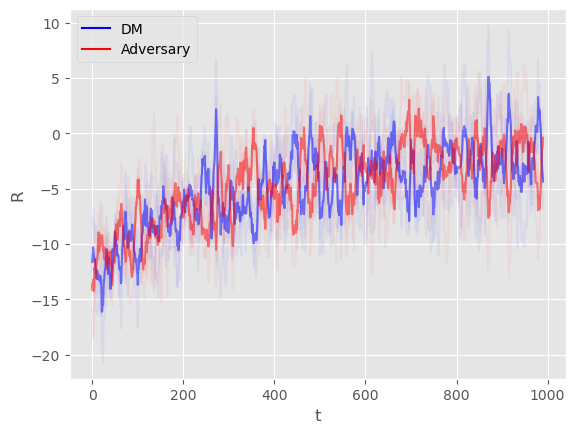

In [8]:
plot(r0ss, r1ss, moving_average_window_size=10, dir = None)

KeyError: 'p0_loc_new'

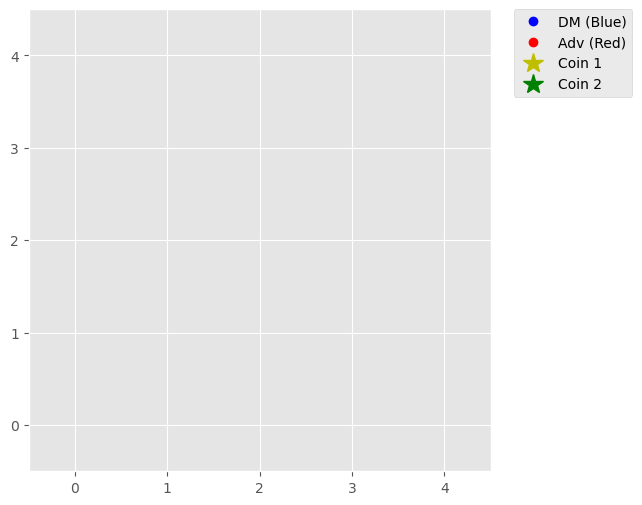

In [11]:
experiment_num_to_display = 1
epoch_idx_to_display = 999

animate_trajectory_from_log(trajectory_logs_all_experiments[experiment_num_to_display][epoch_idx_to_display][:len(trajectory_logs_all_experiments[experiment_num_to_display][epoch_idx_to_display])], grid_size=grid_size, fps=1, dpi=100)


In [10]:
Video(url="trajectory.mp4?cache=" + str(time.time()), embed=False)